# 1-ExtractFeaturesFromDataStructure.ipynb

Inputs Custom AnnData structure containing feature measurements and condenses to a csv for feature selection and subsequent clinical modelling.

In [15]:
import scanpy as sc
import anndata as ad

import warnings
import numpy as np
import pandas as pd
from __future__ import annotations
from typing import SupportsIndex
import numpy as np
from spatial_analysis.utils import ObsHelper
from numpy._typing._array_like import _ArrayLikeComplex_co, _ArrayLikeTD64_co, _ArrayLikeObject_co

In [2]:
# Import the anndata containing the arrays of feature measures
adatat = ad.read_h5ad(r'adjTMA_xbounds_withCNs.h5ad')
adatat

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'PD-L1_pos', 'PD-1_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'PAX5_pos', 'FOXP3_pos', 'Ki67_pos', 'Granzyme_B_pos', 'G6PD_pos', 'pNRF2_pos', 

In [4]:
# Assign an arbitrary feature to group the whole dataset
adatat.obs['core'] = ['0' for _ in range(len(adatat.obs['nb_tumour_nontumour_50_2']))]

/home/akilgall/miniconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


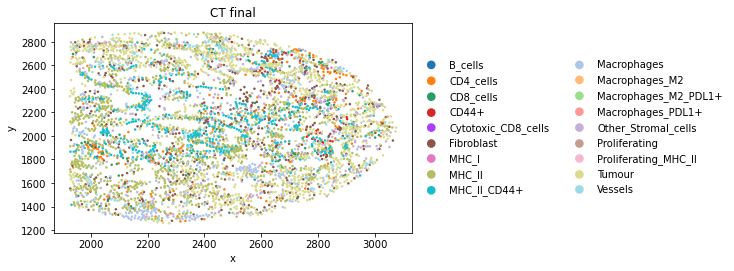

/home/akilgall/miniconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


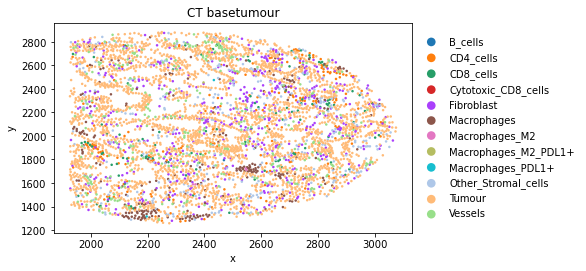

/home/akilgall/miniconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


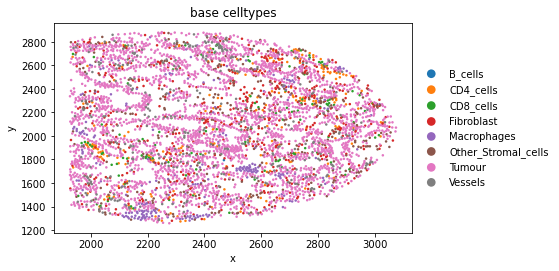

/home/akilgall/miniconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


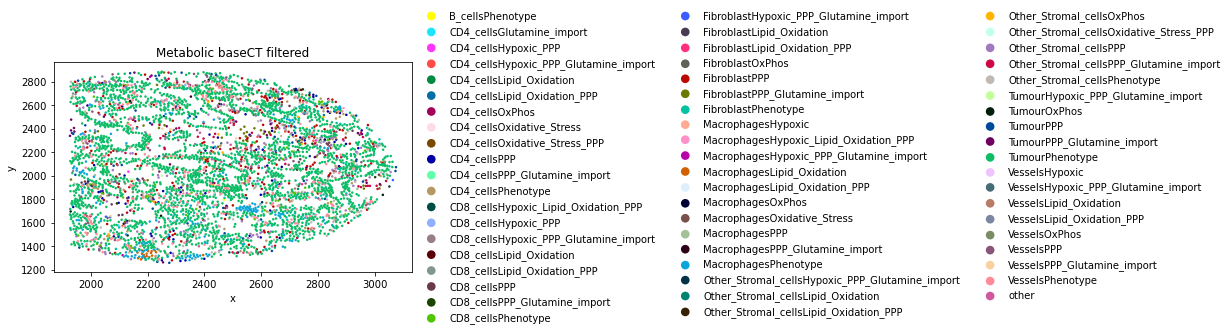

/home/akilgall/miniconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


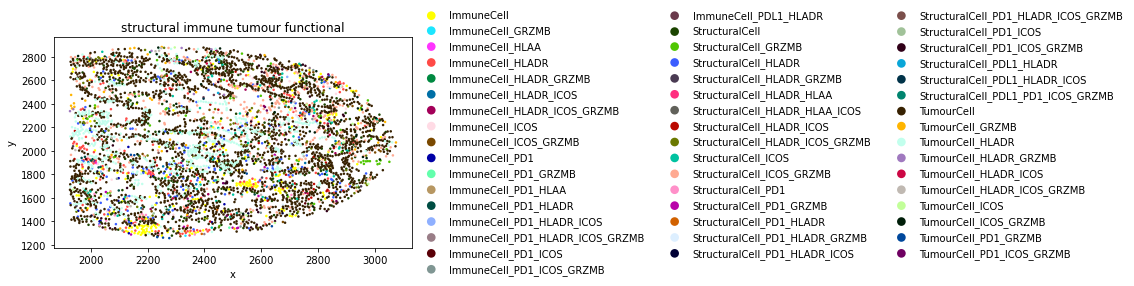

In [6]:
adatat.obs['x'] = adatat.obsm['spatial'][:,0]
adatat.obs['y'] = adatat.obsm['spatial'][:,1]

# Plot some example cores
for core in adatat.obs['unique_core'].unique():
    sc.pl.scatter(adatat[adatat.obs['unique_core'] == core], x='x', y='y', color='CT_final')
    sc.pl.scatter(adatat[adatat.obs['unique_core'] == core], x='x', y='y', color='CT_basetumour')
    sc.pl.scatter(adatat[adatat.obs['unique_core'] == core], x='x', y='y', color='base_celltypes')
    sc.pl.scatter(adatat[adatat.obs['unique_core'] == core], x='x', y='y', color='Metabolic_baseCT_filtered')
    sc.pl.scatter(adatat[adatat.obs['unique_core'] == core], x='x', y='y', color='structural_immune_tumour_functional')
    break

In [7]:
def addKeyedFeatures(adata_, adata_temp, ind):
    print("\t\tadata_.uns['patientIndices'][ind]: ", adata_.uns['patientIndices'][ind])
    for key in adata_temp.obsm.keys():
        adata_.obsm[key][adata_.uns['patientIndices'][ind]] = adata_temp.obsm[key][adata_temp.uns['patientIndices'][ind]]
    return adata_

def iterateAndCopyAll(adata_):
    patients = [a for a, _ in adata_.uns['patientIndices'].items()]
    
    for i, pat in enumerate(patients):
        print(pat, " -- ", i, " / ", len(patients))
        adata_temp = ad.read_h5ad(f'FrameworkTempFiles/patientAnnData_{pat}.h5ad')
        adata_ = addKeyedFeatures(adata_, adata_temp, pat)       

    return adata_

# Remerge or use the previously merged file to save time
#  We will skip as this takes a long time and the temp files are large
regen_merge = False
if regen_merge:
    adata_patientAnnDataMerged = ad.read_h5ad(f'FrameworkTempFiles/patientAnnData_TMA_A_A1.h5ad')
    adata_patientAnnDataMerged = iterateAndCopyAll(adata_patientAnnDataMerged)
    adata_patientAnnDataMerged.write_h5ad(f'patientAnnData_merged.h5ad')
    adata_patientAnnDataMerged
else:
    adata_patientAnnDataMerged = ad.read_h5ad(f'patientAnnData_merged.h5ad')

In [8]:
adata_patientAnnDataMerged.uns.keys()

dict_keys(['CNGroupTypes', 'CT_basetumour', 'CT_final', 'CT_metatumour_funcimmu', 'GCross@k2CNs@CT_basetumour@CT_basetumour@AllCells_dims', 'GCross@k2CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells_dims', 'GCross@k2CNs@Cells@Cells@AllCells_dims', 'GCross@k2CNs@Metabolic_allcells@Metabolic_allcells@AllCells_dims', 'GCross@k2CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells_dims', 'GCross@k2CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells_dims', 'GCross@k3CNs@CT_basetumour@CT_basetumour@AllCells_dims', 'GCross@k3CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells_dims', 'GCross@k3CNs@Cells@Cells@AllCells_dims', 'GCross@k3CNs@Metabolic_allcells@Metabolic_allcells@AllCells_dims', 'GCross@k3CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells_dims', 'GCross@k3CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells_dims', 'GCross@wholeCore@CT_basetumour@CT_basetumour@AllCells_dims', 

In [9]:
# Fast trapz integration of the array values
# https://stackoverflow.com/questions/78065013/skip-nan-values-when-integrating-using-numpy-trapz

def nantrapz(
    y: _ArrayLikeComplex_co | _ArrayLikeTD64_co | _ArrayLikeObject_co,
    x: _ArrayLikeComplex_co | _ArrayLikeTD64_co | _ArrayLikeObject_co | None = None,
    dx: float = 1.0,
    axis: SupportsIndex = -1,
):
    y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        x = np.asanyarray(x)
        if x.ndim == 1:
            d = np.diff(x)
            # reshape to correct shape
            shape = [1] * y.ndim
            shape[axis] = d.shape[0]
            d = d.reshape(shape)
        else:
            d = np.diff(x, axis=axis)
    nd = y.ndim
    slice1 = [slice(None)] * nd
    slice2 = [slice(None)] * nd
    slice1[axis] = slice(1, None)
    slice2[axis] = slice(None, -1)
    try:
        ret = np.nansum(d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0, axis=axis)
    except ValueError:
        # Operations didn't work, cast to ndarray
        d = np.asarray(d)
        y = np.asarray(y)
        ret = np.add.reduce(d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0, axis)
    return ret

In [11]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

labels = []
metrickeys = ['JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_dims', 
              'JSDScores@k2CNs@CT_final@CT_final@AllCells_dims', 'JSDScores@k2CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells_dims', 'JSDScores@k2CNs@Metabolic_allcells@Metabolic_allcells@AllCells_dims', 
              'JSDScores@k2CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells_dims', 'JSDScores@k2CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells_dims', 
              'JSDScores@k3CNs@CT_basetumour@CT_basetumour@AllCells_dims', 'JSDScores@k3CNs@CT_final@CT_final@AllCells_dims', 'JSDScores@k3CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells_dims', 
              'JSDScores@k3CNs@Metabolic_allcells@Metabolic_allcells@AllCells_dims', 'JSDScores@k3CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells_dims', 
              'JSDScores@k3CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells_dims', 'JSDScores@wholeCore@CT_basetumour@CT_basetumour@AllCells_dims', 
              'JSDScores@wholeCore@CT_final@CT_final@AllCells_dims', 'JSDScores@wholeCore@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells_dims', 'JSDScores@wholeCore@Metabolic_allcells@Metabolic_allcells@AllCells_dims', 
              'JSDScores@wholeCore@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells_dims', 'JSDScores@wholeCore@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells_dims']
for metric in metrickeys:
    metric = metric[:-5]
    print(metric)
    labeldict  = adata_patientAnnDataMerged.uns[metric + '_dims']['dimLabels']
    valuesdict = adata_patientAnnDataMerged.uns[metric + '_dims']['dims']

    if 'Edge' in metric:
        valsArr = np.asarray(adata_patientAnnDataMerged.obsm[metric])
        valsArr = nantrapz(valsArr, x=adata_patientAnnDataMerged.uns['radii'], axis=-1)
        for indI, i in enumerate(list(labeldict['0'])):
            for indJ, j in enumerate(list(labeldict['1'])):
                for indK, k in enumerate(list(labeldict['2'])):
                    for indL, l in enumerate(list(labeldict['3'])):
                        labels.append(metric+'_'+str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l))
    elif 'GCross' in metric and 'AllCells' in metric:
        valsArr = np.asarray(adata_patientAnnDataMerged.obsm[metric])
        valsArr = nantrapz(valsArr, x=adata_patientAnnDataMerged.uns['radii'], axis=-1)
        for indI, i in enumerate(list(labeldict['0'])):
            for indJ, j in enumerate(list(labeldict['1'])):
                for indK, k in enumerate(list(labeldict['2'])):
                    labels.append(metric+'_'+str(i)+'_'+str(j)+'_'+str(k))

    elif 'JSD' in metric:
        for indI, i in enumerate(list(labeldict['0'])):
            for indJ, j in enumerate(list(labeldict['1'])):
                for indK, k in enumerate(list(labeldict['2'])):
                    labels.append(metric+'_'+str(i)+'_'+str(j)+'_'+str(k))

    else:
        print("ERROR with ", metric)

JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells
JSDScores@k2CNs@CT_final@CT_final@AllCells
JSDScores@k2CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells
JSDScores@k2CNs@Metabolic_allcells@Metabolic_allcells@AllCells
JSDScores@k2CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells
JSDScores@k2CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells
JSDScores@k3CNs@CT_basetumour@CT_basetumour@AllCells
JSDScores@k3CNs@CT_final@CT_final@AllCells
JSDScores@k3CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells
JSDScores@k3CNs@Metabolic_allcells@Metabolic_allcells@AllCells
JSDScores@k3CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells
JSDScores@k3CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells
JSDScores@wholeCore@CT_basetumour@CT_basetumour@AllCells
JSDScores@wholeCore@CT_final@CT_final@AllCells
JSDScores@wholeCore@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells
JSDScores@who

In [12]:
dfPatientAnnData = pd.DataFrame({})

for metric in metrickeys:
    metric = metric[:-5]
    print(metric)
    labeldict  = adata_patientAnnDataMerged.uns[metric + '_dims']['dimLabels']
    valuesdict = adata_patientAnnDataMerged.uns[metric + '_dims']['dims']

    if 'Edge' in metric:
        valsArr = np.array(adata_patientAnnDataMerged.obsm[metric], dtype=np.float32)
        valsArr = nantrapz(valsArr, x=adata_patientAnnDataMerged.uns['radii'], axis=-1)
        valsArr = valsArr.reshape(valsArr.shape[0], -1)

        templabels = []
        for indI, i in enumerate(list(labeldict['0'])):
            for indJ, j in enumerate(list(labeldict['1'])):
                for indK, k in enumerate(list(labeldict['2'])):
                    for indL, l in enumerate(list(labeldict['3'])):
                        templabels.append(metric+'_'+str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l))
        dftemp = pd.DataFrame(valsArr, index=[_ for _,a in adata_patientAnnDataMerged.uns['patientIndices'].items()], columns=templabels, dtype=np.float32)
        dfPatientAnnData = pd.concat([dfPatientAnnData, dftemp], axis=1)
        
    elif 'GCross' in metric and 'AllCells' in metric:
        valsArr = np.array(adata_patientAnnDataMerged.obsm[metric], dtype=np.float32)
        valsArr = nantrapz(valsArr, x=adata_patientAnnDataMerged.uns['radii'], axis=-1)
        valsArr = valsArr.reshape(valsArr.shape[0], -1)

        templabels = []
        for indI, i in enumerate(list(labeldict['0'])):
            for indJ, j in enumerate(list(labeldict['1'])):
                for indK, k in enumerate(list(labeldict['2'])):
                    templabels.append(metric+'_'+str(i)+'_'+str(j)+'_'+str(k))
        dftemp = pd.DataFrame(valsArr, index=[_ for _,a in adata_patientAnnDataMerged.uns['patientIndices'].items()], columns=templabels, dtype=np.float32)
        dfPatientAnnData = pd.concat([dfPatientAnnData, dftemp], axis=1)
        

    elif 'JSD' in metric:
        valsArr = np.array(adata_patientAnnDataMerged.obsm[metric], dtype=np.float32)
        valsArr = valsArr.reshape(valsArr.shape[0], -1)

        templabels = []
        for indI, i in enumerate(list(labeldict['0'])):
            for indJ, j in enumerate(list(labeldict['1'])):
                for indK, k in enumerate(list(labeldict['2'])):
                    templabels.append(metric+'_'+str(i)+'_'+str(j)+'_'+str(k))
        dftemp = pd.DataFrame(valsArr, index=[_ for _,a in adata_patientAnnDataMerged.uns['patientIndices'].items()], columns=templabels, dtype=np.float32)
        dfPatientAnnData = pd.concat([dfPatientAnnData, dftemp], axis=1)

JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells
JSDScores@k2CNs@CT_final@CT_final@AllCells
JSDScores@k2CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells
JSDScores@k2CNs@Metabolic_allcells@Metabolic_allcells@AllCells
JSDScores@k2CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells
JSDScores@k2CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells
JSDScores@k3CNs@CT_basetumour@CT_basetumour@AllCells
JSDScores@k3CNs@CT_final@CT_final@AllCells
JSDScores@k3CNs@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells
JSDScores@k3CNs@Metabolic_allcells@Metabolic_allcells@AllCells
JSDScores@k3CNs@Metabolic_baseCT_filtered@Metabolic_baseCT_filtered@AllCells
JSDScores@k3CNs@structural_immune_tumour_functional@structural_immune_tumour_functional@AllCells
JSDScores@wholeCore@CT_basetumour@CT_basetumour@AllCells
JSDScores@wholeCore@CT_final@CT_final@AllCells
JSDScores@wholeCore@CT_metatumour_funcimmu@CT_metatumour_funcimmu@AllCells
JSDScores@who

In [13]:
# Import the original data 
adata = ad.read_h5ad(r'adjTMA_xbounds_withCNs.h5ad')
adata

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'PD-L1_pos', 'PD-1_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'PAX5_pos', 'FOXP3_pos', 'Ki67_pos', 'Granzyme_B_pos', 'G6PD_pos', 'pNRF2_pos', 

In [16]:
# Compute the proportions within the core and within the cellular neighbourhoods

nb_cols = ['nb_tumour_nontumour_20_3', 'nb_tumour_nontumour_50_2']
ct_cols = ['CT_basetumour', 'CT_final', 'CT_metatumour_funcimmu', 'Metabolic_allcells', 'Metabolic_baseCT_filtered', 'structural_immune_tumour_functional']

def calculatepropsinnbs(adata, nb_col, ct_col, sample_id):
    agg_helper = ObsHelper(adata, [nb_col, sample_id]) # By core + neighborhood operations
    df= agg_helper.get_metadata_df(ct_col, skey_handle="category_proportions")
    df = df.reset_index().melt(id_vars=[sample_id, nb_col],value_vars=set(adata.obs[ct_col])).pivot(index=sample_id, columns = [ct_col,nb_col], values = 'value').fillna(0)
    df = single_index(df)
    return df

def single_index(data):
    single_indexed = data.columns.map(lambda x: ":".join(x))
    data.columns = single_indexed
    return data

nbproportions = {}
for nb in nb_cols:
    for ct in ct_cols:
        nbproportions[f"{nb}:{ct}"] = calculatepropsinnbs(adata, nb, ct, sample_id ='unique_core')

In [17]:
adata.uns['proportions'] = nbproportions

In [18]:
for key in adata.uns['proportions']:
    nb_temp1 = adata.uns['proportions'][key]
    nb_temp1.index = nb_temp1.index.astype(str)
    val = key.split(':')[1]
    nb_temp1.columns = [f'nb:{val}' + a if a != 'unique_core' else a for a in nb_temp1.columns]

    dfPatientAnnData = pd.concat([dfPatientAnnData, nb_temp1], axis=1)

In [20]:
dfPatientAnnData

,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_M2_PDL1+,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD8_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Fibroblast,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_B_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Cytotoxic_CD8_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_PDL1+,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Vessels,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD4_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Other_Stromal_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_M2,...,nb:structural_immune_tumour_functionalStructuralCell_HLADR_HLAA_ICOS_GRZMB:Stroma,nb:structural_immune_tumour_functionalStructuralCell_HLADR_HLAA_ICOS_GRZMB:Tumour,nb:structural_immune_tumour_functionalImmuneCell_PDL1_PD1_HLAA_GRZMB:Stroma,nb:structural_immune_tumour_functionalImmuneCell_PDL1_PD1_HLAA_GRZMB:Tumour,nb:structural_immune_tumour_functionalTumourCell_HLADR_HLAA_ICOS:Stroma,nb:structural_immune_tumour_functionalTumourCell_HLADR_HLAA_ICOS:Tumour,nb:structural_immune_tumour_functionalStructuralCell_PDL1_PD1_HLADR_ICOS_GRZMB:Stroma,nb:structural_immune_tumour_functionalStructuralCell_PDL1_PD1_HLADR_ICOS_GRZMB:Tumour,nb:structural_immune_tumour_functionalStructuralCell_PD1_HLADR_ICOS:Stroma,nb:structural_immune_tumour_functionalStructuralCell_PD1_HLADR_ICOS:Tumour
TMA_A_A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001192
TMA_A_A2,7.406416e-08,NaN,0.537157,0.622225,0.615246,NaN,0.849263,0.616663,0.768619,0.543558,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000327,0.000000
TMA_A_A3,9.330193e-08,0.722969,0.788028,NaN,0.718408,0.835999,0.766869,0.688993,0.752194,0.727077,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000344,0.001439,0.001204
TMA_A_A4,6.806431e-08,0.664842,0.776310,NaN,0.456688,NaN,0.668055,NaN,0.618023,0.731526,...,0.000000,0.000000,0.003470,0.001013,0.0,0.000000,0.001231,0.000000,0.000895,0.000000
TMA_A_A5,9.913627e-08,NaN,NaN,0.755735,0.784813,0.779400,0.776492,0.862027,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000805,0.000000,0.003379,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA_B_J2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TMA_B_J3,1.544344e-07,0.614802,0.637444,0.793019,0.543209,NaN,0.621604,NaN,0.551935,0.621289,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TMA_B_J4,1.047855e-07,NaN,NaN,0.722901,0.717682,0.701548,0.771249,0.838836,NaN,NaN,...,0.000000,0.000000,0.000190,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TMA_B_J7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000166,0.000000,0.0,0.000161,0.000000,0.000000,0.000000,0.000000


In [21]:
#JSD of similar cell types in the same CN are irrelevant and add complexity to the modelling due to colinearity

drop_columns = []
jsd_cols = dfPatientAnnData.columns[dfPatientAnnData.columns.str.contains('JSD')]
for col in jsd_cols:
    for cn in range(4):
        if len(col.split('_'+str(cn)+'_')) > 1:
            colsplit = col.split('_'+str(cn)+'_')[1]
            if colsplit[:len(colsplit)//2] == colsplit[len(colsplit)//2+1:]:
                drop_columns.append(col)
dfPatientAnnData = dfPatientAnnData.drop(columns=drop_columns,axis=1)

In [22]:
dfPatientAnnData

,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD8_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Fibroblast,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_B_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Cytotoxic_CD8_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_PDL1+,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Vessels,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD4_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Other_Stromal_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_M2,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD4_TFH,...,nb:structural_immune_tumour_functionalStructuralCell_HLADR_HLAA_ICOS_GRZMB:Stroma,nb:structural_immune_tumour_functionalStructuralCell_HLADR_HLAA_ICOS_GRZMB:Tumour,nb:structural_immune_tumour_functionalImmuneCell_PDL1_PD1_HLAA_GRZMB:Stroma,nb:structural_immune_tumour_functionalImmuneCell_PDL1_PD1_HLAA_GRZMB:Tumour,nb:structural_immune_tumour_functionalTumourCell_HLADR_HLAA_ICOS:Stroma,nb:structural_immune_tumour_functionalTumourCell_HLADR_HLAA_ICOS:Tumour,nb:structural_immune_tumour_functionalStructuralCell_PDL1_PD1_HLADR_ICOS_GRZMB:Stroma,nb:structural_immune_tumour_functionalStructuralCell_PDL1_PD1_HLADR_ICOS_GRZMB:Tumour,nb:structural_immune_tumour_functionalStructuralCell_PD1_HLADR_ICOS:Stroma,nb:structural_immune_tumour_functionalStructuralCell_PD1_HLADR_ICOS:Tumour
TMA_A_A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001192
TMA_A_A2,NaN,0.537157,0.622225,0.615246,NaN,0.849263,0.616663,0.768619,0.543558,0.564840,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000327,0.000000
TMA_A_A3,0.722969,0.788028,NaN,0.718408,0.835999,0.766869,0.688993,0.752194,0.727077,0.718037,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000344,0.001439,0.001204
TMA_A_A4,0.664842,0.776310,NaN,0.456688,NaN,0.668055,NaN,0.618023,0.731526,0.604721,...,0.000000,0.000000,0.003470,0.001013,0.0,0.000000,0.001231,0.000000,0.000895,0.000000
TMA_A_A5,NaN,NaN,0.755735,0.784813,0.779400,0.776492,0.862027,NaN,NaN,0.761949,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000805,0.000000,0.003379,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA_B_J2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TMA_B_J3,0.614802,0.637444,0.793019,0.543209,NaN,0.621604,NaN,0.551935,0.621289,0.541761,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TMA_B_J4,NaN,NaN,0.722901,0.717682,0.701548,0.771249,0.838836,NaN,NaN,NaN,...,0.000000,0.000000,0.000190,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TMA_B_J7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000166,0.000000,0.0,0.000161,0.000000,0.000000,0.000000,0.000000


# Add GCross Features

G-Cross features were computed in two iterations.  One without the metabolic phenotype and one with.

In [24]:
adataCorrected = ad.read_h5ad(f'adjTMA_xbounds_all_minus_metabolic.h5ad')

In [25]:
adataCorrected

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'PD-L1_pos', 'PD-1_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'PAX5_pos', 'FOXP3_pos', 'Ki67_pos', 'Granzyme_B_pos', 'G6PD_pos', 'pNRF2_pos', 

In [26]:
gcorsskeys = ['CT_basetumour_gcross_auc_hanish_unbiased_500.0', 'CT_final_gcross_auc_hanish_unbiased_500.0', 
              'CT_metatumour_funcimmu_gcross_auc_hanish_unbiased_500.0', 'Metabolic_allcells_gcross_auc_hanish_unbiased_500.0']
for a in gcorsskeys:
    adataCorrected.uns[a].columns = ['_'.join(a.split('_')[0:2]) + '@' + colname for colname in adataCorrected.uns[a].columns]
gcrosspd = pd.concat([adataCorrected.uns[a] for a in gcorsskeys], axis=1)
gcrosspd.columns = ['GCrossCorr@' + colname for colname in gcrosspd.columns]

In [27]:
gcrosspd

,GCrossCorr@CT_basetumour@B_cells_to_B_cells,GCrossCorr@CT_basetumour@B_cells_to_CD4_TFH,GCrossCorr@CT_basetumour@B_cells_to_CD4_cells,GCrossCorr@CT_basetumour@B_cells_to_CD8_cells,GCrossCorr@CT_basetumour@B_cells_to_Cytotoxic_CD8_cells,GCrossCorr@CT_basetumour@B_cells_to_Fibroblast,GCrossCorr@CT_basetumour@B_cells_to_Macrophages,GCrossCorr@CT_basetumour@B_cells_to_Macrophages_M2,GCrossCorr@CT_basetumour@B_cells_to_Macrophages_M2_PDL1+,GCrossCorr@CT_basetumour@B_cells_to_Macrophages_PDL1+,...,GCrossCorr@Metabolic_allcells@Phenotype_to_OxPhos_Lipid_Oxidation,GCrossCorr@Metabolic_allcells@Phenotype_to_OxPhos_Lipid_Oxidation_PPP,GCrossCorr@Metabolic_allcells@Phenotype_to_OxPhos_PPP,GCrossCorr@Metabolic_allcells@Phenotype_to_Oxidative_Stress,GCrossCorr@Metabolic_allcells@Phenotype_to_Oxidative_Stress_Glutamine_import,GCrossCorr@Metabolic_allcells@Phenotype_to_Oxidative_Stress_PPP,GCrossCorr@Metabolic_allcells@Phenotype_to_Oxidative_Stress_PPP_Glutamine_import,GCrossCorr@Metabolic_allcells@Phenotype_to_PPP,GCrossCorr@Metabolic_allcells@Phenotype_to_PPP_Glutamine_import,GCrossCorr@Metabolic_allcells@Phenotype_to_Phenotype
TMA_A_A1,NaN,NaN,445.000000,415.000000,NaN,485.000000,435.000000,395.000000,NaN,NaN,...,NaN,NaN,303.761144,NaN,NaN,NaN,NaN,467.445172,356.938495,488.406851
TMA_A_A2,490.538275,460.086361,479.256717,476.661717,170.388037,449.348358,459.821911,408.643244,227.485230,187.169446,...,NaN,NaN,NaN,319.010825,125.773349,404.214488,354.875706,427.920082,439.075256,493.218300
TMA_A_A3,417.503988,437.469576,485.449896,428.512009,NaN,465.811809,447.845298,429.226859,352.067019,364.123618,...,NaN,NaN,NaN,170.806822,114.388687,196.697660,242.333275,451.720977,414.326385,488.815022
TMA_A_A4,460.984167,479.762630,489.766069,440.892074,348.213978,475.849288,436.145540,398.574180,469.170034,439.603366,...,NaN,NaN,292.706633,108.166895,61.046481,281.292517,228.478335,472.028217,444.869116,491.087858
TMA_A_A5,490.539889,444.197279,478.751343,447.705913,NaN,459.428892,459.110793,425.084647,190.528797,371.725350,...,NaN,NaN,NaN,405.297458,310.774432,434.734815,372.179933,474.625305,461.748472,491.291466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA_B_J2,327.042021,NaN,467.920938,478.202219,NaN,484.962005,476.538307,454.630306,NaN,NaN,...,NaN,NaN,NaN,467.385398,369.910882,432.203110,233.555695,475.872686,432.213292,488.452753
TMA_B_J3,327.201489,349.926802,481.034310,478.454952,356.725321,447.044861,465.241388,462.702017,471.117562,448.655934,...,178.308456,NaN,NaN,406.544974,404.450658,252.741115,276.768280,465.343044,460.612153,484.575300
TMA_B_J4,440.142266,104.691597,483.883937,481.400865,NaN,485.258610,490.545836,480.403575,439.743821,447.285339,...,NaN,NaN,NaN,278.485837,NaN,296.042512,242.080957,484.950323,475.208100,480.879110
TMA_B_J7,489.706042,400.410065,490.561351,483.479581,134.797297,466.997717,481.672052,451.556409,406.272548,433.985501,...,354.400376,136.073991,381.545746,399.878204,384.284795,128.384172,230.085726,457.024505,471.122375,487.420996


In [28]:
adataCorrected2 = ad.read_h5ad(f'adjTMA_xbounds_Metabolic_baseCT_filtered.h5ad')

In [29]:
adataCorrected2

AnnData object with n_obs × n_vars = 1187511 × 48
    obs: 'Image', 'Object ID', 'Name', 'TMA core', 'Parent', 'ROI', 'x', 'y', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'tumour_nontumour', 'immunecelltypes', 'CD4_type', 'CD8_type', 'mac_type', 'Tumour_type', 'Tumour_type_tidy', 'unique_core', 'patientID', 'adjtma_PCF_repA', 'adjtma_PCF_repB', 'dict', 'DSP_WTA_ROI', 'TNM', 'stage', 'PathwayCode', 'Histology', 'Sex', 'Smoking', 'EndCycle', 'DOB', 'Date of surgery', 'StartDate', 'Deceased', 'DateDeceased', 'Relapse', 'Date of relapse', 'Molecular profile', 'Mutation', 'Last known contact', 'Surv_status', 'Surv_Followup', 'Relapse_status', 'Relapse_followup', 'tregion', 'tumourdist', 'Tumour_area', 'Tumour_pc', 'Stroma_area', 'Stroma_pc', 'CT_final', 'CT_basetumour', 'base_celltypes', 'batch', 'PD-L1_pos', 'PD-1_pos', 'HLA-DR_pos', 'HLA-A_pos', 'ICOS(CD278)_pos', 'PAX5_pos', 'FOXP3_pos', 'Ki67_pos', 'Granzyme_B_pos', 'G6PD_pos', 'pNRF2_pos', 

In [30]:
gcorsskeys = ['Metabolic_baseCT_filtered_gcross_auc_hanish_unbiased_500.0']

In [31]:
for a in gcorsskeys:
    adataCorrected2.uns[a].columns = ['_'.join(a.split('_')[0:2]) + '@' + colname for colname in adataCorrected2.uns[a].columns]
gcrosspd2 = pd.concat([adataCorrected2.uns[a] for a in gcorsskeys], axis=1)
gcrosspd2.columns = ['GCrossCorr@' + colname for colname in gcrosspd2.columns]

In [32]:
gcrosspd2

,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsGlutamine_import,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic_Glutamine_import,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic_Lipid_Oxidation,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic_Lipid_Oxidation_PPP,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic_Oxidative_Stress,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic_PPP,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsHypoxic_PPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsLipid_Oxidation,GCrossCorr@Metabolic_baseCT@B_cellsGlutamine_import_to_B_cellsLipid_Oxidation_Glutamine_import,...,GCrossCorr@Metabolic_baseCT@other_to_VesselsLipid_Oxidation_PPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxPhos,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress_PPP,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress_PPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsPPP,GCrossCorr@Metabolic_baseCT@other_to_VesselsPPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsPhenotype,GCrossCorr@Metabolic_baseCT@other_to_other
TMA_A_A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,385.613031,NaN,NaN,NaN,NaN,433.501224,333.077131,431.793927,337.227165
TMA_A_A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,475.000000,NaN,NaN,NaN,384.434136,NaN
TMA_A_A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TMA_A_A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.860160,268.985438
TMA_A_A5,370.205370,68.636149,NaN,NaN,NaN,NaN,132.889812,NaN,426.052076,NaN,...,NaN,NaN,319.223959,NaN,319.080967,NaN,415.000000,404.068475,393.750860,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA_B_J2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TMA_B_J3,495.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.362279,15.000000,...,NaN,NaN,115.000000,229.868331,NaN,NaN,NaN,257.630666,445.989963,125.000000
TMA_B_J4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TMA_B_J7,449.582761,NaN,373.436345,298.935968,NaN,NaN,NaN,327.969280,475.998503,423.121071,...,288.895090,NaN,NaN,NaN,NaN,NaN,279.974137,312.713011,372.714492,414.567379


In [33]:
dfPatientAnnData = pd.concat([dfPatientAnnData, gcrosspd, gcrosspd2], axis=1)

In [34]:
dfPatientAnnData

,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD8_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Fibroblast,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_B_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Cytotoxic_CD8_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_PDL1+,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Vessels,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD4_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Other_Stromal_cells,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_Macrophages_M2,JSDScores@k2CNs@CT_basetumour@CT_basetumour@AllCells_0_Macrophages_M2_PDL1+_CD4_TFH,...,GCrossCorr@Metabolic_baseCT@other_to_VesselsLipid_Oxidation_PPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxPhos,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress_PPP,GCrossCorr@Metabolic_baseCT@other_to_VesselsOxidative_Stress_PPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsPPP,GCrossCorr@Metabolic_baseCT@other_to_VesselsPPP_Glutamine_import,GCrossCorr@Metabolic_baseCT@other_to_VesselsPhenotype,GCrossCorr@Metabolic_baseCT@other_to_other
TMA_A_A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,385.613031,NaN,NaN,NaN,NaN,433.501224,333.077131,431.793927,337.227165
TMA_A_A2,NaN,0.537157,0.622225,0.615246,NaN,0.849263,0.616663,0.768619,0.543558,0.564840,...,NaN,NaN,NaN,NaN,475.000000,NaN,NaN,NaN,384.434136,NaN
TMA_A_A3,0.722969,0.788028,NaN,0.718408,0.835999,0.766869,0.688993,0.752194,0.727077,0.718037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TMA_A_A4,0.664842,0.776310,NaN,0.456688,NaN,0.668055,NaN,0.618023,0.731526,0.604721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.860160,268.985438
TMA_A_A5,NaN,NaN,0.755735,0.784813,0.779400,0.776492,0.862027,NaN,NaN,0.761949,...,NaN,NaN,319.223959,NaN,319.080967,NaN,415.000000,404.068475,393.750860,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA_B_J2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TMA_B_J3,0.614802,0.637444,0.793019,0.543209,NaN,0.621604,NaN,0.551935,0.621289,0.541761,...,NaN,NaN,115.000000,229.868331,NaN,NaN,NaN,257.630666,445.989963,125.000000
TMA_B_J4,NaN,NaN,0.722901,0.717682,0.701548,0.771249,0.838836,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TMA_B_J7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,288.895090,NaN,NaN,NaN,NaN,NaN,279.974137,312.713011,372.714492,414.567379


In [35]:
dfPatientAnnData.to_csv(f'df_integrated_patientAnnData_merged.csv')

PermissionError: [Errno 13] Permission denied: '/df_integrated_patientAnnData_merged.csv'